This notebook takes hydrodynamics data of various yachts based on the 43' sloop by Standmast and uses a neural network to predict hull performance. The data was obtained from the UCI machine learning repository and was created by the Delft Ship Hydrodynamics Laboratory for the purpose of predicting the residuary hull resistance, which is used for estimating the required propulsive power of the vessel. The data consists of 308 full scale experiments of 22 different hull forms.  

The model is a nonlinear regression model using Pytorch.

In [18]:
# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD

In [19]:
# read and display the data
df = pd.read_csv('yacht_hydrodynamics.data', delim_whitespace=True)
df

,-2.3,0.568,4.78,3.99,3.17,0.125,0.11
0,-2.3,0.568,4.78,3.99,3.17,0.150,0.27
1,-2.3,0.568,4.78,3.99,3.17,0.175,0.47
2,-2.3,0.568,4.78,3.99,3.17,0.200,0.78
3,-2.3,0.568,4.78,3.99,3.17,0.225,1.18
4,-2.3,0.568,4.78,3.99,3.17,0.250,1.82
...,...,...,...,...,...,...,...
302,-2.3,0.600,4.34,4.23,2.73,0.350,8.47
303,-2.3,0.600,4.34,4.23,2.73,0.375,12.27
304,-2.3,0.600,4.34,4.23,2.73,0.400,19.59
305,-2.3,0.600,4.34,4.23,2.73,0.425,30.48


The provided columns are:
1. Center of Bouyancy (longitudinal position)
2. Prismatic coefficient
3. Length-displacement ratio
4. Beam-draught ratio
5. Length-beam ratio
6. Froude number
7. Residuary resistance - measured variable

The goal of this dataset is to find a way to predict values for residuary resistance based on the previous column.

In [20]:
# add column names
df.rename(columns={ df.columns[0]: 'cob', df.columns[1]: 'prism_coef', df.columns[2]: 'ld_ratio', df.columns[3]: 'bd_ratio',\
                   df.columns[4]: 'lb_ratio', df.columns[5]: 'froude', df.columns[6]: 'rr'}, inplace=True)
df

,cob,prism_coef,ld_ratio,bd_ratio,lb_ratio,froude,rr
0,-2.3,0.568,4.78,3.99,3.17,0.150,0.27
1,-2.3,0.568,4.78,3.99,3.17,0.175,0.47
2,-2.3,0.568,4.78,3.99,3.17,0.200,0.78
3,-2.3,0.568,4.78,3.99,3.17,0.225,1.18
4,-2.3,0.568,4.78,3.99,3.17,0.250,1.82
...,...,...,...,...,...,...,...
302,-2.3,0.600,4.34,4.23,2.73,0.350,8.47
303,-2.3,0.600,4.34,4.23,2.73,0.375,12.27
304,-2.3,0.600,4.34,4.23,2.73,0.400,19.59
305,-2.3,0.600,4.34,4.23,2.73,0.425,30.48


In [21]:
# check for missing entries
df.isna().sum()

cob           0
prism_coef    0
ld_ratio      0
bd_ratio      0
lb_ratio      0
froude        0
rr            0
dtype: int64

Making the Neural Network

In [22]:
# create torch tensors 
index = 5
X = torch.from_numpy(df.iloc[:, [index]].values).float()
Y = torch.from_numpy(df['rr'].values).float()

In [23]:
# add dimension to Y to match X
Y = Y.unsqueeze(1)
print(f'X: {X.shape} Y: {Y.shape}')

X: torch.Size([307, 1]) Y: torch.Size([307, 1])


In [24]:
# define number of samples and features
n_samples, n_features = X.shape

In [25]:
# define input and output size of the network
input_size = n_features
output_size = 1
hidden_size = 3

In [26]:
# create the neural network
class NonLinearModel(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(NonLinearModel, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size) # first part of first linear layer
        self.relu = nn.ReLU() # second part of first layer - activation function

        self.layer2 = nn.Linear(hidden_size, output_size) # second linear layer
        
    # forward pass
    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        yhat = self.layer2(x)

        return yhat
    
        

In [27]:
# create model object from class
model = NonLinearModel(input_size, hidden_size, output_size)

In [28]:
# define optimizer and loss
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [29]:
# training loop
epochs = 100
total_loss = []

for epoch in range(epochs):
    Yhat = model(X)
    loss_batch = criterion(Yhat, Y)
    total_loss.append(loss_batch.item())

    for x, y in zip(X, Y):

        yhat = model(x)

        loss = criterion(yhat, y)

        loss.backward()

        optimizer.step()

        optimizer.zero_grad()

    Yhat = model(X) 

In [30]:
# use model to make predictions
predicted = model(X).detach().numpy()

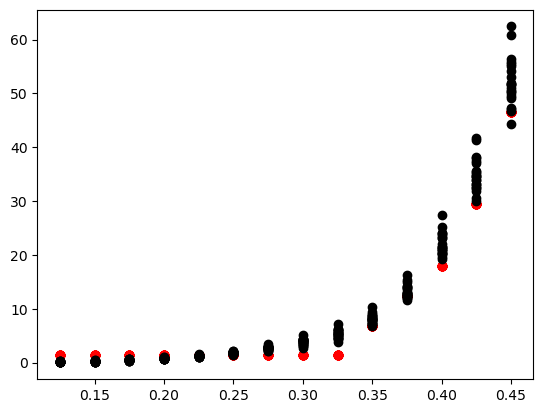

In [31]:
# plot predicted values
plt.plot(df.iloc[:,index].values, predicted, 'ro')
plt.plot(df.iloc[:,index].values, Y, 'ko')
plt.show()

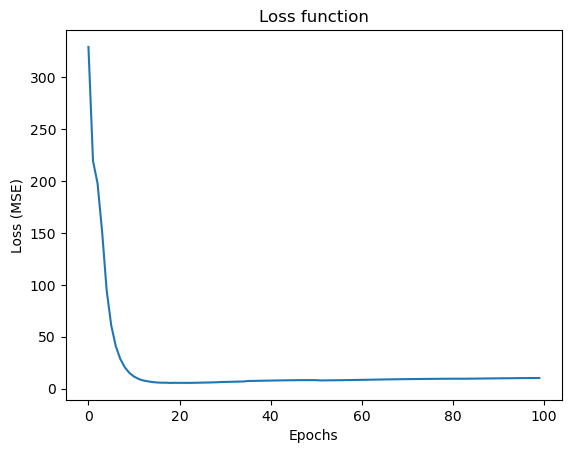

In [32]:
# plot the loss function
x_line = range(epochs)
plt.plot(x_line, total_loss)
plt.ylabel('Loss (MSE)')
plt.xlabel('Epochs')
plt.title('Loss function')
plt.show()